# Earnings Forecast - Roland Berger Analytics Screening

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle



In [2]:
sp500 = pd.read_csv('SP500_FUND_A_16052019.csv', index_col=0)

print('Number of rows: ', sp500.shape[0])
print('Number of Features: ', sp500.shape[1])

sp500.head()

Number of rows:  5339
Number of Features:  118


,ticker,date,year,month,day,fyear,fmonth,ass_c_y,ass_nc_y,ass_tax_y,...,rat_y,rev_r_d_y,rev_s_g_a_y,roic_y,turn_acc_pay_y,turn_acc_rec_y,turn_inv_y,wrk_cap_y,fyearold,n2
v1,,,,,,,,,,,,,,,,,,,,,
1,a,2007-10-31,2007,10,31,2007,10,3.671000e+09,3.883000e+09,0.0,...,2.207,0.1264,0.3137,0.1490,4.1255,7.5964,8.5354,2.008000e+09,2007,1
2,a,2008-10-31,2008,10,31,2008,10,3.182000e+09,3.825000e+09,0.0,...,2.392,0.1219,0.2939,0.1864,4.6941,7.6731,8.9589,1.852000e+09,2008,1
3,a,2009-10-31,2009,10,31,2009,10,3.961000e+09,3.651000e+09,0.0,...,3.527,0.1433,0.3577,0.0121,3.7951,6.5656,7.4808,2.838000e+09,2009,1
4,a,2010-10-31,2010,10,31,2010,10,6.169000e+09,3.527000e+09,0.0,...,2.001,0.1124,0.3218,0.0905,3.9107,7.4372,8.5868,3.086000e+09,2010,1
5,a,2011-10-31,2011,10,31,2011,10,5.569000e+09,3.488000e+09,0.0,...,3.032,0.0981,0.2735,0.1700,3.5592,7.6518,8.1970,3.732000e+09,2011,1


## 1. Data Preparation

### 1.1 Dataset containing 23 predictors

In [3]:
selection = ['ticker', 'date', 'year', 'month', 'day', 'fyear', 'fmonth', 'shr_y', 'ass_tot_y', 'goodwill_y', 'inc_rea_y', 'invest_y', 'rev_def_y', 'dps_y',
                'exp_r_d_y', 'marg_profit_y', 'rev_grw_y', 'cf_inv_y', 'exp_cap_y',
                'ncf_bad_y', 'ncf_iad_y', 'g_cf_op_y', 'g_dps_y', 'g_eps_y', 'g_inv_y',
                'be_ps_y', 'fcf_ps_y', 'inc_qua_y', 'payout_y', 'turn_inv_y', 'eps_y']


sp500_selected = sp500[selection]

df_predictors = sp500_selected.drop(columns='eps_y')

df_predictors.head()

,ticker,date,year,month,day,fyear,fmonth,shr_y,ass_tot_y,goodwill_y,...,ncf_iad_y,g_cf_op_y,g_dps_y,g_eps_y,g_inv_y,be_ps_y,fcf_ps_y,inc_qua_y,payout_y,turn_inv_y
v1,,,,,,,,,,,,,,,,,,,,,
1,a,2007-10-31,2007,10,31,2007,10,394000000.0,7.554000e+09,7.360000e+08,...,1.600000e+07,0.5284,0.0,-0.7888,0.0255,8.601,2.099,1.5188,0.0,8.5354
2,a,2008-10-31,2008,10,31,2008,10,363000000.0,7.007000e+09,8.740000e+08,...,-7.300000e+07,-0.2198,0.0,0.1790,0.0047,7.168,1.697,1.0909,0.0,8.9589
3,a,2009-10-31,2009,10,31,2009,10,346000000.0,7.612000e+09,8.220000e+08,...,8.000000e+07,-0.4603,0.0,-1.0471,-0.1455,7.306,0.812,-13.1613,0.0,7.4808
4,a,2010-10-31,2010,10,31,2010,10,347000000.0,9.696000e+09,1.950000e+09,...,4.800000e+07,0.7598,0.0,22.8889,0.2971,9.384,1.741,1.0497,0.0,8.5868
5,a,2011-10-31,2011,10,31,2011,10,347000000.0,9.057000e+09,1.996000e+09,...,1.561000e+09,0.7549,0.0,0.4822,0.2542,12.415,3.141,1.2451,0.0,8.1970


### 1.2 Scaling variables of variables - share / absolute level

First, let's assess if the number of stocks vary over time. This helps us decide for an approach of scaling to the per stock level, leaving the numbers in absolute terms or using an alternative method.

In [4]:
df_shr_changes = sp500.groupby('ticker')['shr_y'].nunique()
tickers_with_shr_changes = df_shr_changes[df_shr_changes > 1].index.tolist()

if tickers_with_shr_changes:
    print(f"The 'shr_y' (shares per year) changes over time for the following tickers: {tickers_with_shr_changes}")
else:
    print("The 'shr_y' (shares per year) does not change over time for any ticker in the dataset.")


The 'shr_y' (shares per year) changes over time for the following tickers: ['a', 'aal', 'aap', 'aapl', 'abbv', 'abc', 'abt', 'acn', 'adbe', 'adi', 'adm', 'adp', 'ads', 'adsk', 'aee', 'aep', 'aes', 'aet', 'afl', 'agn', 'aig', 'aiv', 'aiz', 'ajg', 'akam', 'aks', 'alb', 'alk', 'all', 'alle', 'alxn', 'amat', 'amd', 'ame', 'amg', 'amgn', 'amp', 'amt', 'amzn', 'an', 'anf', 'antm', 'aon', 'apa', 'apc', 'apd', 'aph', 'are', 'arnc', 'ati', 'atvi', 'avb', 'avgo', 'avp', 'avy', 'awk', 'axp', 'ayi', 'azo', 'ba', 'bac', 'bax', 'bbby', 'bbt', 'bby', 'bc', 'bcr', 'bdx', 'ben', 'bfb', 'big', 'biib', 'bk', 'blk', 'bll', 'bms', 'bmy', 'brkb', 'bsx', 'bwa', 'bxp', 'c', 'ca', 'cag', 'cah', 'cat', 'cb', 'cbg', 'cboe', 'cbs', 'cce', 'cci', 'ccl', 'celg', 'cern', 'cf', 'cfg', 'chd', 'chk', 'chrw', 'chtr', 'ci', 'cien', 'cinf', 'cl', 'clf', 'clx', 'cma', 'cmcsa', 'cme', 'cmg', 'cmi', 'cms', 'cnc', 'cnp', 'cnx', 'cof', 'cog', 'coh', 'col', 'coo', 'cop', 'cost', 'coty', 'cpb', 'crm', 'csco', 'csx', 'ctas', 'ctl

For many of the companies in the dataset, share number vary over time. A share split for example would cause the share number to double, while the earnings per share would halve.

However, after assessing whether to scale the varaibles that are recorded in absolute terms, for the purpose of this exercise, we will scale all variables to a per share level.

For a more extensive analysis than a 24h project, one could further assess to use relative metrics, such as R&D spend / revenue.

In [5]:
# all variables that are on a absolute level that are to be scaled on a per share basis
# -> ratios and percentages are not considered here

absolute_variables_to_scale = {
    'ass_tot_y': 'ass_ps_y',
    'goodwill_y': 'goodwill_ps_y',
    'inc_rea_y': 'inc_rea_ps_y',
    'invest_y': 'invest_ps_y',
    'rev_def_y': 'rev_def_ps_y',
    'exp_r_d_y': 'exp_r_d_ps_y',
    'cf_inv_y': 'cf_inv_ps_y',
    'exp_cap_y': 'exp_cap_ps_y',
    'ncf_bad_y': 'ncf_bad_ps_y',
    'ncf_iad_y': 'ncf_iad_ps_y',
}

# scale each variable
for original, new_name in absolute_variables_to_scale.items():
    df_predictors[new_name] = df_predictors[original] / df_predictors['shr_y']

# update predictor columns list with new per-share variables
predictor_cols_scaled = [
    'ticker',           # 0. Company ticker
    'date',             # 0. Time stemp
    'year',             # 0. Time stemp
    'month',            # 0. Time stemp
    'day',              # 0. Time stemp
    'fyear',            # 0. Time stemp
    'fmonth',           # 0. Time stemp
    'shr_y',            # 0. Number of shares

    'ass_ps_y',         # 1. Scaled (was ass_tot_y)
    'goodwill_ps_y',    # 2. Scaled (was goodwill_y)
    'inc_rea_ps_y',     # 3. Scaled (was inc_rea_y)
    'invest_ps_y',      # 4. Scaled (was invest_y)
    'rev_def_ps_y',     # 5. Scaled (was rev_def_y)
    'dps_y',            # 6. Unchanged
    'exp_r_d_ps_y',     # 7. Scaled (was exp_r_d_y)
    'marg_profit_y',    # 8. Unchanged
    'rev_grw_y',        # 9. Unchanged
    'cf_inv_ps_y',      # 10. Scaled (was cf_inv_y)
    'exp_cap_ps_y',     # 11. Scaled (was exp_cap_y)
    'ncf_bad_ps_y',     # 12. Scaled (was ncf_bad_y)
    'ncf_iad_ps_y',     # 13. Scaled (was ncf_iad_y)
    'g_cf_op_y',        # 14. Unchanged
    'g_dps_y',          # 15. Unchanged
    'g_eps_y',          # 16. Unchanged
    'g_inv_y',          # 17. Unchanged
    'be_ps_y',          # 18. Unchanged (Already per share)
    'fcf_ps_y',         # 19. Unchanged (Already per share)
    'inc_qua_y',        # 20. Unchanged
    'payout_y',         # 21. Unchanged
    'turn_inv_y'        # 22. Unchanged
]

# Now use predictor_cols_scaled for your analysis
X = df_predictors[predictor_cols_scaled]
X.head()

,ticker,date,year,month,day,fyear,fmonth,shr_y,ass_ps_y,goodwill_ps_y,...,ncf_iad_ps_y,g_cf_op_y,g_dps_y,g_eps_y,g_inv_y,be_ps_y,fcf_ps_y,inc_qua_y,payout_y,turn_inv_y
v1,,,,,,,,,,,,,,,,,,,,,
1,a,2007-10-31,2007,10,31,2007,10,394000000.0,19.172589,1.868020,...,0.040609,0.5284,0.0,-0.7888,0.0255,8.601,2.099,1.5188,0.0,8.5354
2,a,2008-10-31,2008,10,31,2008,10,363000000.0,19.303030,2.407713,...,-0.201102,-0.2198,0.0,0.1790,0.0047,7.168,1.697,1.0909,0.0,8.9589
3,a,2009-10-31,2009,10,31,2009,10,346000000.0,22.000000,2.375723,...,0.231214,-0.4603,0.0,-1.0471,-0.1455,7.306,0.812,-13.1613,0.0,7.4808
4,a,2010-10-31,2010,10,31,2010,10,347000000.0,27.942363,5.619597,...,0.138329,0.7598,0.0,22.8889,0.2971,9.384,1.741,1.0497,0.0,8.5868
5,a,2011-10-31,2011,10,31,2011,10,347000000.0,26.100865,5.752161,...,4.498559,0.7549,0.0,0.4822,0.2542,12.415,3.141,1.2451,0.0,8.1970


### 1.3 Creating target variables

First, we create a DataFrame that contains the data for the current financial year.

In [6]:
# creating df with target variable & additional features

Y = sp500[['ticker', 'date', 'year', 'month', 'day', 'fyear', 'shr_y','fmonth', 'eps_y']]
Y.head()

,ticker,date,year,month,day,fyear,shr_y,fmonth,eps_y
v1,,,,,,,,,
1,a,2007-10-31,2007,10,31,2007,394000000.0,10,1.62
2,a,2008-10-31,2008,10,31,2008,363000000.0,10,1.91
3,a,2009-10-31,2009,10,31,2009,346000000.0,10,-0.09
4,a,2010-10-31,2010,10,31,2010,347000000.0,10,1.97
5,a,2011-10-31,2011,10,31,2011,347000000.0,10,2.92


In [7]:
# creating a new target variable - displays if current eps_y is negative - to be shifted

Y['neg_eps'] = Y['eps_y'] < 0
Y.head()

/var/folders/yn/2tfz0n9x7m3dkwb69m05y8lw0000gn/T/ipykernel_56255/3034734157.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y['neg_eps'] = Y['eps_y'] < 0


,ticker,date,year,month,day,fyear,shr_y,fmonth,eps_y,neg_eps
v1,,,,,,,,,,
1,a,2007-10-31,2007,10,31,2007,394000000.0,10,1.62,False
2,a,2008-10-31,2008,10,31,2008,363000000.0,10,1.91,False
3,a,2009-10-31,2009,10,31,2009,346000000.0,10,-0.09,True
4,a,2010-10-31,2010,10,31,2010,347000000.0,10,1.97,False
5,a,2011-10-31,2011,10,31,2011,347000000.0,10,2.92,False


Now, having all the data in a Dataframe, we need to shift the two target variables - these will later be the target variables for the prediction model.

In [8]:
# shift eps_y and neg_eps by 1 to creat the actual target variables

Y['eps_y_forward'] = Y['eps_y'].shift(-1)
Y['neg_eps_forward'] = Y['neg_eps'].shift(-1)
Y.tail()

/var/folders/yn/2tfz0n9x7m3dkwb69m05y8lw0000gn/T/ipykernel_56255/1219482884.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y['eps_y_forward'] = Y['eps_y'].shift(-1)
/var/folders/yn/2tfz0n9x7m3dkwb69m05y8lw0000gn/T/ipykernel_56255/1219482884.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y['neg_eps_forward'] = Y['neg_eps'].shift(-1)


,ticker,date,year,month,day,fyear,shr_y,fmonth,eps_y,neg_eps,eps_y_forward,neg_eps_forward
v1,,,,,,,,,,,,
5473,zts,2012-12-31,2012,12,31,2012,500000000.0,12,0.87,False,1.01,False
5474,zts,2013-12-31,2013,12,31,2013,500002000.0,12,1.01,False,1.16,False
5475,zts,2014-12-31,2014,12,31,2014,501055000.0,12,1.16,False,0.68,False
5476,zts,2015-12-31,2015,12,31,2015,499707000.0,12,0.68,False,1.66,False
5477,zts,2016-12-31,2016,12,31,2016,495715000.0,12,1.66,False,NaN,NaN


In [9]:
# filter for one company to check correctness

company = 'nke'
nke = Y[Y['ticker'] == company]

nke

,ticker,date,year,month,day,fyear,shr_y,fmonth,eps_y,neg_eps,eps_y_forward,neg_eps_forward
v1,,,,,,,,,,,,
3626,nke,2008-05-31,2008,5,31,2008,1.970841e+09,5,0.95,False,0.77,False
3627,nke,2009-05-31,2009,5,31,2009,1.937394e+09,5,0.77,False,0.98,False
3628,nke,2010-05-31,2010,5,31,2010,1.942802e+09,5,0.98,False,1.14,False
3629,nke,2011-05-31,2011,5,31,2011,1.896520e+09,5,1.14,False,1.23,False
3630,nke,2012-05-31,2012,5,31,2012,1.833472e+09,5,1.23,False,1.38,False
3631,nke,2013-05-31,2013,5,31,2013,1.787229e+09,5,1.38,False,1.52,False
3632,nke,2014-05-31,2014,5,31,2014,1.756278e+09,5,1.52,False,1.90,False
3633,nke,2015-05-31,2015,5,31,2015,1.719495e+09,5,1.90,False,2.21,False
3634,nke,2016-05-31,2016,5,31,2016,1.684722e+09,5,2.21,False,-1.57,True


Before moving on to the EDA, we want to first make sure that the data is prepared properly.

#### Previous assumption was that a stock split for example might cause a significant structural break in the data.
First research has yielded that this might not be the case, because EPS is always reported on a split-adjusted basis by financial data providers. However, we want to check if this is the case and if so, adjust for it.

We will research one specific commpanies where a stock split occurred in the time period of the data. Then we will check if the data is actually reported on a split-adjusted basis to validate our new hypothesis.

According to credible sources, including the company website, Nike (ticker: nke) had a 2-for1 stock split in 12/23/2015. Accordingly, we will check how the number of shares changed over time:


https://investors.nike.com/default.aspx?SectionId=d8f26c6c-d0e6-416b-af21-d4193a16d945&LanguageId=1

In [10]:
print(nke[nke['year'].isin([2014, 2015, 2016])]['shr_y'])


v1
3632    1.756278e+09
3633    1.719495e+09
3634    1.684722e+09
Name: shr_y, dtype: float64


Accordingly, as the number of shares does not double from 2015 to 2016, we can continue with this hypothesis and now have confirmed that there is *no adjustment necessary*.

### 1.4 Outlier Detection & Treatment

### a. Identification of Outliers

In [11]:
def detect_outliers_and_bounds(df, features, threshold=1.5):
    """
    Detects outliers using IQR method and calculates bounds for winsorizing.
    
    Parameters:
    - df: The dataframe
    - features: List of continuous variables to check
    - threshold: IQR multiplier (Standard is 1.5)
    
    Returns:
    - outlier_flags: DataFrame with binary outlier flags (1=outlier, 0=normal)
    - bounds: Dictionary with lower/upper bounds for each feature
    """
    print(f"--- Detecting Outliers (IQR Threshold={threshold}) ---")
    
    outlier_flags = pd.DataFrame(index=df.index)
    bounds = {}
    
    for col in features:
        if col not in df.columns:
            continue
            
        # Calculate IQR Bounds
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - (threshold * IQR)
        upper_bound = Q3 + (threshold * IQR)
        
        # Store bounds for winsorizing
        bounds[col] = {'lower': lower_bound, 'upper': upper_bound}
        
        # Flag outliers
        is_outlier = (df[col] < lower_bound) | (df[col] > upper_bound)
        outlier_flags[col] = is_outlier.astype(int)
    
    return outlier_flags, bounds


def count_outliers_by_ticker(df, outlier_flags):
    """
    Counts how many individual outlier values exist for each ticker.
    
    Parameters:
    - df: The dataframe (must contain a 'ticker' column)
    - outlier_flags: DataFrame with binary outlier flags
    
    Returns:
    - results: DataFrame sorted by most outliers, filtered for tickers with >= 1
    """
    print(f"--- Aggregating Outliers by Ticker ---")
    
    # Add Ticker column back for grouping
    outlier_flags_copy = outlier_flags.copy()
    
    if 'ticker' in df.columns:
        outlier_flags_copy['ticker'] = df['ticker'].values
    else:
        outlier_flags_copy['ticker'] = df.index.get_level_values('ticker')

    # Group by Ticker and Sum
    ticker_totals = outlier_flags_copy.groupby('ticker').sum()
    
    # Sum across columns to get grand total per ticker
    results = pd.DataFrame()
    results['outlier_count'] = ticker_totals.sum(axis=1)
    
    # Filter: Minimum of 1 outlier
    results = results[results['outlier_count'] >= 1]
    
    # Sort descending
    results = results.sort_values(by='outlier_count', ascending=False)
    
    return results

In [ ]:
sp500_selected

# Select numeric features for outlier detection
features_ol_id = sp500_selected.select_dtypes(include=np.number).columns.drop(
    ['ticker', 'date', 'year', 'month', 'fyear', 'fmonth', 'shr_y'], 
    errors='ignore'
).tolist()

# Detect outliers and get bounds (run once, use twice)
outlier_flags, outlier_bounds = detect_outliers_and_bounds(sp500_selected, features_ol_id, threshold=1.5)

# Count outliers per company
outliers_per_company = count_outliers_by_ticker(sp500_selected, outlier_flags)

# Calculate total data points checked
total_data_points = len(sp500_selected) * len(features_ol_id)
total_outliers = outlier_flags.sum().sum()
outlier_percentage = (total_outliers / total_data_points) * 100

print(f"\nTotal data points checked: {total_data_points:,}")
print(f"Total outliers detected: {total_outliers:,} ({outlier_percentage:.2f}%)")
print(f"Companies with outliers: {len(outliers_per_company)} out of {sp500_selected['ticker'].nunique()}")

# Display top companies with most outliers
outliers_per_company.head(10)

--- Detecting Outliers (IQR Threshold=2.5) ---
--- Aggregating Outliers by Ticker ---

Total data points checked: 128,136
Total outliers detected: 13,185 (10.29%)
Companies with outliers: 572 out of 579


,outlier_count
ticker,
googl,107
brkb,104
ibm,103
aapl,101
c,98
aig,93
fnma,91
cvx,87
gs,86


Accordingly, around 14% of the feature & target values present in the dataset outliers. With an absolute count of 18,028 outliers, these extreme values possess high leverage that would disproportionately skew the coefficients of a General Linear Model (GLM), undermining its predictive accuracy for the broader market.
As one can see, most of the outliers are present in the large companies of the S&P 500 (IBM, Citi Group, Google, Apple, Microsoft, ect.), which are much bigger than the some of the smaller companies represented in the S&P500.

In [24]:
outlier_flags, outlier_bounds = detect_outliers_and_bounds(sp500_selected, features_ol_id, threshold=2.5)

# Count outliers per company
outliers_per_company = count_outliers_by_ticker(sp500_selected, outlier_flags)

# Calculate total data points checked
total_data_points = len(sp500_selected) * len(features_ol_id)
total_outliers = outlier_flags.sum().sum()
outlier_percentage = (total_outliers / (len(sp500_selected) * len(features_ol_id))) * 100

print("\n")
print(f"Total outliers detected: {total_outliers:,} ({outlier_percentage:.2f}%)")

--- Detecting Outliers (IQR Threshold=2.5) ---
--- Aggregating Outliers by Ticker ---


Total outliers detected: 13,185 (10.29%)


This will will accordingly result in capping/clipping ~10% of the values in the dataset, reducing the share of altered data.

### b. Handling of Outliers

Since the occurrences of outliers is quite high, we will use the winsorization method with an adjusted threshold of 2.5 to reduce the impact of the most extreme values while not altering too much of the original data.

Whether to winsorize the target feature along with the predictors is a trade-off between stabilizing the regression model and preserving rare but true observations.
The decision to also winsorize the target variable was made to ensure structural consistency, as attempting to predict extreme target values using capped or clipped predictors creates an unbalanced equation that forces the GLM to artificially inflate coefficients.

In [13]:
def winsorize_data(df, features, bounds):
    """
    Winsorizes data by capping outliers at the IQR bounds.
    
    Parameters:
    - df: The dataframe to winsorize
    - features: List of features to winsorize
    - bounds: Dictionary of bounds from detect_outliers_and_bounds
    
    Returns:
    - df_winsorized: DataFrame with outliers capped at bounds
    """
    print(f"--- Winsorizing {len(features)} features ---")
    
    df_winsorized = df.copy()
    winsorized_count = 0
    
    for col in features:
        if col not in bounds or col not in df_winsorized.columns:
            continue
            
        lower = bounds[col]['lower']
        upper = bounds[col]['upper']
        
        # Count how many values will be winsorized
        n_lower = (df_winsorized[col] < lower).sum()
        n_upper = (df_winsorized[col] > upper).sum()
        winsorized_count += n_lower + n_upper
        
        # Cap values at bounds
        df_winsorized[col] = df_winsorized[col].clip(lower=lower, upper=upper)
    
    print(f"Winsorized {winsorized_count} values across all features")
    return df_winsorized


Therefore, we need to calculate the new 2.5 IQR bounds for the windorizing.

In [14]:
def get_iqr_bounds(df, features, threshold):
    bounds = {}
    for col in features:
        if col not in df.columns: continue
        
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        bounds[col] = {
            'lower': Q1 - (threshold * IQR),
            'upper': Q3 + (threshold * IQR)
        }
    return bounds


    

In [25]:
_, new_bounds = detect_outliers_and_bounds(sp500_selected, features_ol_id, threshold=2.5)

# Apply winsorizing using the bounds we already calculated
sp500_winsorized = winsorize_data(sp500_selected, features_ol_id, new_bounds)
# Verify winsorizing worked - should have 0 outliers with same bounds
outlier_flags_after, _ = detect_outliers_and_bounds(sp500_winsorized, features_ol_id, threshold=2.5)
print(f"\nOutliers remaining after winsorizing: {outlier_flags_after.sum().sum()}")

sp500_winsorized

--- Detecting Outliers (IQR Threshold=2.5) ---
--- Winsorizing 24 features ---
Winsorized 13185 values across all features
--- Detecting Outliers (IQR Threshold=2.5) ---

Outliers remaining after winsorizing: 0


,ticker,date,year,month,day,fyear,fmonth,shr_y,ass_tot_y,goodwill_y,...,g_cf_op_y,g_dps_y,g_eps_y,g_inv_y,be_ps_y,fcf_ps_y,inc_qua_y,payout_y,turn_inv_y,eps_y
v1,,,,,,,,,,,,,,,,,,,,,
1,a,2007-10-31,2007,10,31,2007,10,394000000.0,7.554000e+09,7.360000e+08,...,0.5284,0.0000,-0.788800,0.0255,8.601,2.099,1.518800,0.000,8.5354,1.62
2,a,2008-10-31,2008,10,31,2008,10,363000000.0,7.007000e+09,8.740000e+08,...,-0.2198,0.0000,0.179000,0.0047,7.168,1.697,1.090900,0.000,8.9589,1.91
3,a,2009-10-31,2009,10,31,2009,10,346000000.0,7.612000e+09,8.220000e+08,...,-0.4603,0.0000,-1.047100,-0.1455,7.306,0.812,-1.721225,0.000,7.4808,-0.09
4,a,2010-10-31,2010,10,31,2010,10,347000000.0,9.696000e+09,1.950000e+09,...,0.7598,0.0000,1.690475,0.2971,9.384,1.741,1.049700,0.000,8.5868,1.97
5,a,2011-10-31,2011,10,31,2011,10,347000000.0,9.057000e+09,1.996000e+09,...,0.7549,0.0000,0.482200,0.2542,12.415,3.141,1.245100,0.000,8.1970,2.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5473,zts,2012-12-31,2012,12,31,2012,12,500000000.0,6.262000e+09,1.853000e+09,...,-0.0865,0.0000,0.775500,0.2653,8.052,0.656,1.041300,0.000,3.6013,0.87
5474,zts,2013-12-31,2013,12,31,2013,12,500002000.0,6.558000e+09,1.785000e+09,...,0.5000,0.0000,0.160900,-0.0387,1.880,0.994,1.351200,0.198,3.4579,1.01
5475,zts,2014-12-31,2014,12,31,2014,12,501055000.0,6.588000e+09,1.703000e+09,...,-0.0808,0.4500,0.148500,-0.0031,2.614,0.890,1.073800,0.250,3.7064,1.16


### 1.5 EDA

#### Distribution of Earnings per Share

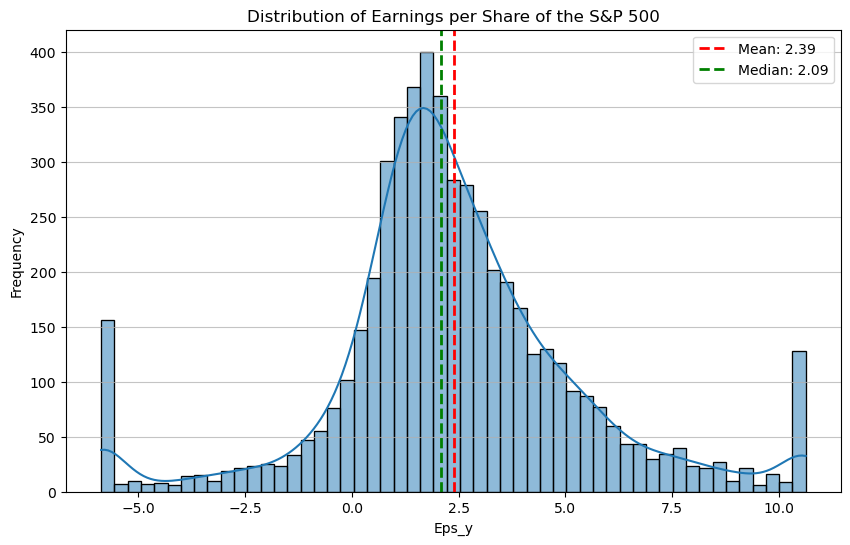

In [30]:
mean_eps_y = sp500_winsorized['eps_y'].mean()
median_eps_y = sp500_winsorized['eps_y'].median()

plt.figure(figsize=(10, 6))
sns.histplot(sp500_winsorized['eps_y'], bins='auto', kde=True)
plt.axvline(mean_eps_y, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_eps_y:.2f}')
plt.axvline(median_eps_y, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_eps_y:.2f}')
plt.title('Distribution of Earnings per Share of the S&P 500')
plt.xlabel('Eps_y')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.legend()
plt.show()


Representative for the overall dataset after windsorizing, one can see the 'inflated' tails on the very far sides of the histogram.
This is due to the fact that the windsorizing process has cut the distrubution of the data on the left and right side respectively and put it into the most outside bucket that was mainted without alteration.

One can see that most companies are profitable with the mean laying at 2.39.

#### Correlation Heatmap - Top 10 Correlated Predictors (to Target Variable)

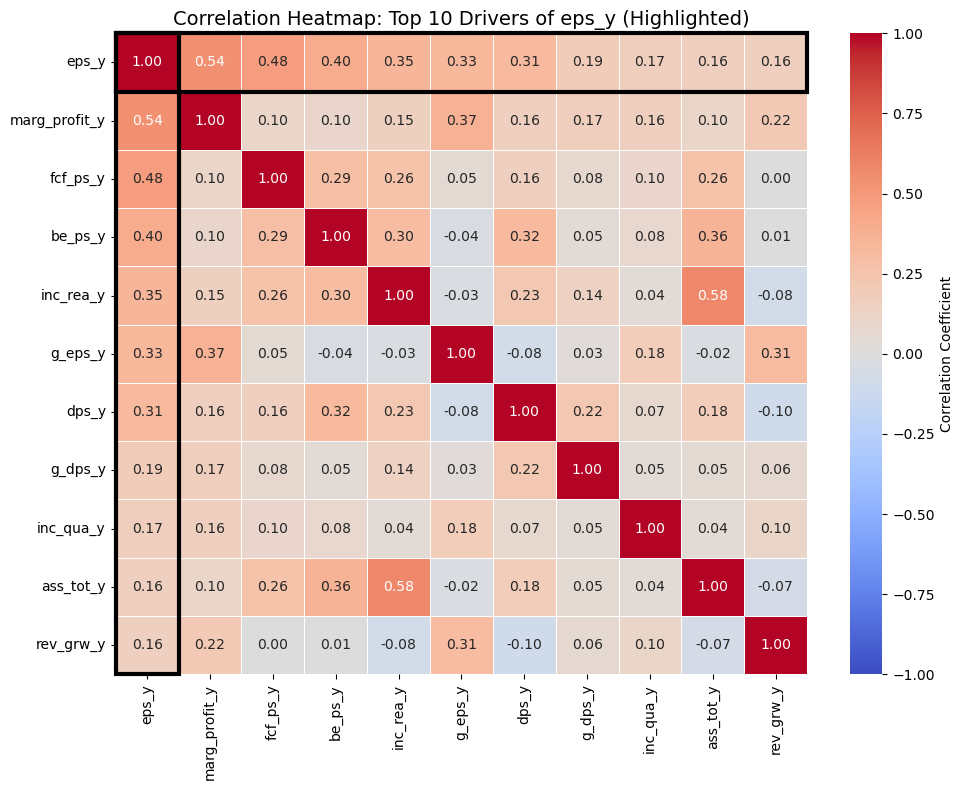

In [45]:
# 1. Select only numeric columns
numeric_df = sp500_winsorized.select_dtypes(include=[np.number])
target = 'eps_y'

# 2. Select Top 10 Features + Target
if target in numeric_df.columns:
    # Get correlations
    correlations = numeric_df.corrwith(numeric_df[target]).abs()
    # Sort and take top 11 (Target + 10 best predictors)
    top_features = correlations.sort_values(ascending=False).head(11).index.tolist()
    
    # 3. Create Heatmap
    plt.figure(figsize=(10, 8))
    corr_matrix = numeric_df[top_features].corr()
    
    # Plot heatmap
    ax = sns.heatmap(
        corr_matrix, 
        annot=True, 
        fmt=".2f", 
        cmap='coolwarm', 
        vmin=-1, vmax=1,
        linewidths=0.5,
        cbar_kws={'label': 'Correlation Coefficient'}
    )
    
    # 4. Highlight the Target Row and Column
    # Find where 'eps_y' is in the list (it should be index 0, but we check to be safe)
    target_idx = top_features.index(target)
    n_vars = len(top_features)
    
    # Draw Rectangle around the 'eps_y' Column
    ax.add_patch(Rectangle((target_idx, 0), 1, n_vars, fill=False, edgecolor='black', lw=3, clip_on=False))
    
    # Draw Rectangle around the 'eps_y' Row
    ax.add_patch(Rectangle((0, target_idx), n_vars, 1, fill=False, edgecolor='black', lw=3, clip_on=False))
    
    plt.title(f"Correlation Heatmap: Top 10 Drivers of {target} (Highlighted)", fontsize=14)
    plt.tight_layout()
    plt.show()

else:
    print(f"Target '{target}' not found in DataFrame.")

From this visualization, we can see that profit margin, free cash flow per share, and book value per share are most highly correlated to the target variable (earning per share).